In [1]:
import sys
import os, os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

/home/ayush.sharma/miniconda3/envs/prep/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ayush.sharma/miniconda3/envs/prep/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


## Globals

In [3]:
root_dir = "~/prep/data/"


## Data Loader

In [4]:
# Define transformations (resize to 32x32 as ViT generally takes larger inputs)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 for ViT input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize MNIST data: The MNIST dataset has pixel values in the range [0, 1]
])

## The data will now be in the range [-1, 1]

train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False) # No shuffle as test set. 



### Sanity check

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

## Config

In [6]:
from dataclasses import dataclass

@dataclass
class Config():
    num_epochs: int = 10
    batch_size: int = 64
    channels: int = 1
    image_size: int = 32
    patch_size: int = 16 # should divide image size
    num_patches: int = (image_size // patch_size) ** 2
    embed_dim: int = patch_size * patch_size
    num_transformer_blocks: int = 6 # Paper uses 12 blocks. But since MNIST is small, I use 6
    num_heads: int = 4
    num_classes: int=10 # 10 classes in MNIST
    device: str = "cuda" 
   
    
    
    


## Auxiliary function

In [7]:
def patchify_image(data: torch.Tensor, patch_size: int) -> torch.Tensor:
    batch_size, channels, H, W = data.shape
    assert H % patch_size == 0 and W % patch_size == 0
    patches = data.unfold(dimension=2, size=patch_size, step=patch_size).unfold(dimension=3, size=patch_size, step=patch_size)
    
    patches = patches.contiguous().view(batch_size, -1, patch_size * patch_size * channels)
    # Patches has shape [num_batch, num_patch, patch_size * patch_size]. Note seq_len is also called num_patch 
    return patches
    
# patches = patchify_image(images, Config.patch_size)
# patches.shape
    
    


## Model architecture

### Multi head attention block

<img src="../assets/mha.png" alt="Multi head attention"> <br>


In [8]:
class SelfAttentionBlock(nn.Module):
    
    def __init__(self, num_heads: int, input_dim: int, embed_dim: int):
        super(SelfAttentionBlock, self).__init__()
        self.num_heads = num_heads
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        
        # Linear projections for queries, keys, and values
        self.queries = nn.Linear(input_dim, embed_dim)
        self.keys = nn.Linear(input_dim, embed_dim)
        self.values = nn.Linear(input_dim, embed_dim)
        
        # Now we need to combine the output. A layer for that
        self.out = nn.Linear(embed_dim, input_dim)
        
    def forward(self, x: torch.tensor):
        batch_size, seq_len, input_dim = x.shape   
        assert input_dim == self.input_dim # the one provided in cofig and the one in input should match
        per_head_dim = self.embed_dim // self.num_heads
                            
                             
        # Projecting the input to find queries, keys and values
        Q = self.queries(x)
        K = self.keys(x)
        V = self.values(x)
                                 
        # split the Q, K, V across individual heads 
        # Note that we want the output to be [batch_size, num_heads, seq_len, per_head_dim]
        Q = Q.view(x.size(0), x.size(1), self.num_heads, per_head_dim).transpose(1, 2)
        K = K.view(x.size(0), x.size(1), self.num_heads, per_head_dim).transpose(1, 2)
        V = V.view(x.size(0), x.size(1), self.num_heads, per_head_dim).transpose(1, 2)
        
        scale = torch.sqrt(torch.tensor(per_head_dim, dtype=torch.float32))
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / scale # shape: [batch_size, num_heads, seq_len, seq_len]
        attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # Multiply by V to get the attention output. 
        # Note we don't use * as its element wise multiplicaton. We want matmul usch as:
        # [batch_size, num_heads, seq_len, seq_len] <dot> [batch_size, num_heads, seq_len, per_head_dim]
        attention_output = torch.matmul(attention_weights, V) # shape: [batch_size, num_heads, seq_len, per_head_dim]
        
        attention_output_og_shape = attention_output.transpose(1,2).contiguous() # transpose makes a tensor not-contiguous. So , make a new contigous copy
        attention_output_og_shape = attention_output_og_shape.view(batch_size, seq_len, self.embed_dim)
        
        # Note that we cold have also done it using reshape
        # attention_output_og_shape = attention_output.transpose(1, 2).reshape(x.size(0), x.size(1), self.embed_dim)
        
        output = self.out(attention_output_og_shape)
        return output

        
        


### Questions <br>


#### 1. What is sequence length here?
Answer: THe sequence length here is the number of patches of the image. The ViT authors make the analogy being each grid is a word and `[patch_size x patch_size` is the dimension of the embedding of that word.

#### 2. Why do we use transpose in this part of the code? <br>
```
Q = Q.view(x.size(0), x.size(1), self.num_heads, per_head_dim).transpose(1, 2)
K = K.view(x.size(0), x.size(1), self.num_heads, per_head_dim).transpose(1, 2)
V = V.view(x.size(0), x.size(1), self.num_heads, per_head_dim).transpose(1, 2)
```

Answer:
 - After reshaping the tensor into [batch_size, seq_len, num_heads, head_dim], we need to change the order of the dimensions so that the num_heads dimension comes before the sequence length (seq_len). This is necessary because we want to compute attention independently for each head.
 - By transposing, we rearrange the tensor into:
   `[batch_size, num_heads, seq_len, per_head_dim]`
   we can now apply attention on the last 2 dimensions which is `sequence_length`, `per_head_dim`


#### 3. (Important) Given word embeddings of dimension 128 for a sequence of 10 words (so, shape [batch_size, 10, 128]), if we linearly project these into queries of shape [batch_size, 10, 128], and then apply multi-head attention:
 - Why does multi-head attention split the word embedding into chunks?
 - **Doesn't this splitting lose the meaning of the word embedding**?
 
Answer: <br>
- Let's take an input example <br>
    Input Example: Word embedding has shape [batch_size, 10, 128], where:
    - 10 is the number of words in the sequence.
    - 128 is the word embedding dimension.

- Linear Projection:
  Each word embedding (128-dimensional) is linearly projected into queries, keys, and values before splitting into heads.
  
- Splitting Across Heads:
  After projection, multi-head attention splits the transformed representations, not the raw word embeddings.
  For 8 heads, the projected queries are split into 8 parts of size 16 (128 / 8 = 16).
  
- The linear projections allow each head to attend to a **different transformed representation of the word embedding**, enabling multiple diverse attention patterns.

- Each head focuses on a portion of the transformed embedding, but not directly splitting the original embedding.

- The core reason we don’t directly project into a [batch_size, seq_len, num_heads, head_dim] space (where num_heads × head_dim = input_dim) is **primarily for flexibility and efficient parameter sharing**



<img src="../assets/transformer_model_architecture.png" alt="ViT architecture"> <br>


In [9]:
class TransformerBlock(nn.Module):
    
    def __init__(self, num_heads: int, 
                 input_dim: int, 
                 embed_dim: int):
        super(TransformerBlock, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(input_dim) ## Normalize before attention
        self.mha = SelfAttentionBlock(num_heads, input_dim, embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim) # layer norm after the transformer MHA block
        self.ffn = nn.Sequential(
                      nn.Linear(embed_dim, embed_dim * 4), 
                      nn.ReLU(),
                      nn.Linear(embed_dim * 4, embed_dim)
        )
        
    def forward(self, x: torch.tensor):
        batch_size, seq_len, input_dim = x.shape
        assert input_dim == self.input_dim, "The shapes of input dim specified in constructor and the data are not same"

        # Multi-head attention block
        attn_output = self.mha(self.norm1(x))  # Apply LayerNorm first
        x = x + attn_output  # Residual connection after attention

        # Feed-forward network block
        ffn_output = self.ffn(self.norm2(x))  # Apply LayerNorm first
        output = x + ffn_output  # Residual connection after feed-forward
        return output

        
        

### 4. Why do we use LayerNorm in Transformers?

Answer: There are multiple benefits to using LayerNorm in Transformer. The main reason we use it with Transformer, is that because transformers attend to individual tokens independently. So taking norm across the layer dimensions gives a more representative output as each token in `[batch, seq_len, embed_dim]` has its own feature space of `[embed_dim]`
- LayerNorm is especially useful for transformers since each token is processed individually in attention mechanisms, and LayerNorm ensures that the representation of each token is properly normalized, leading to more effective training.
- LayerNorm helps stabilize the training process by normalizing the inputs across the feature dimensions (i.e. normalizing with each token) and ensuring they have zeron mean and variance. This tackles the problem of exploding or vanishing gradients. 
- It helps stabilize residual connections by preventing large values from accumulating when residuals are added, ensuring smooth information flow through the network.


### 5. Why don't we apply ReLU after second linear layer?
```
self.ffn = nn.Sequential(
                      nn.Linear(embed_dim, embed_dim * 4), 
                      nn.ReLU(),
                      nn.Linear(embed_dim * 4, embed_dim)
        )
```
- **Loss of information before sum**: The final output from the FFN (after the second linear layer) is typically added to the residual connection, which expects the full range of values (both positive and negative) to maintain flexibility in representation. Applying ReLU after the second layer would clip all negative values, potentially losing information.
- **Redundant Non Linearity**: 
    - The purpose of the ReLU (or GELU) activation function is to introduce non-linearity to the model, which helps it learn more complex patterns. After the first linear layer, the ReLU adds this non-linearity.
    - Applying another ReLU after the second linear layer would reduce flexibility because the second linear layer's purpose is to project back to the original feature space. Keeping it linear allows the output to maintain the structure needed for the next layer.


In [10]:
cfg = Config()
print(cfg)

Config(num_epochs=10, batch_size=64, channels=1, image_size=32, patch_size=16, num_patches=4, embed_dim=256, num_transformer_blocks=6, num_heads=4, num_classes=10, device='cuda')


In [11]:
class ViT(nn.Module):
    
    def __init__(self, cfg: Config):
        super(ViT, self).__init__()
        self.cfg = cfg
        num_patches = cfg.num_patches
        embed_dim = cfg.embed_dim
        input_dim = cfg.patch_size ** 2
        
        
        # parameters for positional embedding
        # we use a learable positional embed as used in ViT paper
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, input_dim))
        self.transformers = nn.Sequential(
                                *[TransformerBlock(cfg.num_heads, cfg.patch_size ** 2, cfg.embed_dim) for _ in range(cfg.num_transformer_blocks)]
                            )
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(cfg.patch_size ** 2, cfg.num_classes)  # For 10 MNIST classes

        
    def forward(self, x: torch.tensor):
        patches = patchify_image(x, self.cfg.patch_size)
        assert patches.shape[1] == self.cfg.num_patches, \
            f"Number of patches {patches.shape[1]} should match {self.cfg.num_patches}"
       
        # At this point patches shape: [batch_size,  seq_len, input_dim]
        patches = patches + self.pos_embed  
        x = patches.contiguous()
        x = self.transformers(x) # [batch_size,  seq_len, embed_dim]
        
        # Transpose for AdaptiveAvgPool1d to pool over the sequence length
        x = x.transpose(1, 2)  # Shape: [batch_size, embed_dim, seq_len]
        x = self.global_avg_pool(x) # Apply adaptive pooling to get [batch_size, embed_dim, 1]
        x = x.squeeze(-1)
        out = self.classifier(x)
        return out

## Training loop

In [12]:
import torch.optim as optim
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter Lab (From stack Overflow)



def train(cfg: Config,
          model: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          criterion, 
         ):
    num_epochs = cfg.num_epochs
    device = cfg.device
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            # print(images.shape, labels.shape)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': running_loss / (idx + 1), 
                'Accuracy': 100 * correct / total
            })

        print(f'Epoch {epoch+1} finished. Training Accuracy: {100 * correct / total:.2f}%')
    print("Finished Training")            
        

cfg = Config()
model = ViT(cfg)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=3e-4)
train(cfg, model, train_loader, criterion)
        

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 finished. Training Accuracy: 92.50%


Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 finished. Training Accuracy: 96.97%


Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 finished. Training Accuracy: 97.63%


Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 finished. Training Accuracy: 97.88%


Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 finished. Training Accuracy: 98.27%


Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 finished. Training Accuracy: 98.38%


Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 finished. Training Accuracy: 98.41%


Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 finished. Training Accuracy: 98.62%


Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 finished. Training Accuracy: 98.73%


Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 finished. Training Accuracy: 98.66%
Finished Training


# Test the model

In [18]:
from sklearn.metrics import precision_score, recall_score



def test(model, test_loader, criterion):
    device = cfg.device
    model.to(device)  
    model.eval()  # Set model to evaluation mode. Don't forget this.
    
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during testing
        for images, labels in tqdm(test_loader, desc='Testing', leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Store predictions and labels for precision/recall
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate precision and recall for the test set
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    return avg_loss, precision, recall

In [19]:
avg_test_loss, precision, recall = test(model, test_loader, criterion)

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.0859, Precision: 0.9760, Recall: 0.9742


## Visualize results

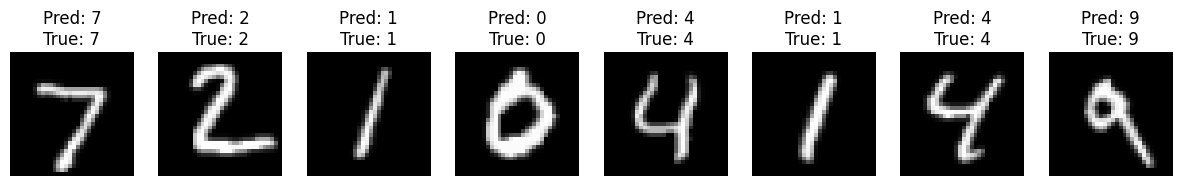

In [24]:
 from torchvision.utils import make_grid

def visualize_results(cfg, model, test_loader,num_images=8):
    device = cfg.device
    classes = [str(i) for i in range(cfg.num_classes)]  # For MNIST, class labels are 0-9

    model.eval()  # Set the model to evaluation mode
    
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Move the images and labels to the appropriate device (GPU or CPU)
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():  # No need to calculate gradients during inference
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Move the images and labels back to the CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    
    # Plot the images with predicted and true labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].squeeze().numpy()  # Convert to NumPy array and remove single channel
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}')
        ax.axis('off')
    
    plt.show()

# Example usage
visualize_results(cfg, model, test_loader)
